# <center> Battle of the Neighbourhoods
## <center> Coursera Capstone Project  
<font size="5">
<ol> 
<li>
    <dl> 
        <dt>  Introduction  </dt>
        <dd> <font size="4"> 
            Shanghai, the most populous city in China, is a perfect amalgmation of Chinese and international cultures. It attracts over 300 million visitors a year, both from within China and outside of it. Businessmen, tourists, students, there are all kinds of people there.  The aim of the project is to create a catalogue for people visiting Shanghai to select Hotels to stay at based on their distance from the airport and most frequently visited locations in Shanghai. The project will be using data acquired from Foursquare API services and coded in python to produce the required results.
            </font> </dd><br>
        <dt> Problem Statement/Background Discussion</dt> 
        <dd><font size="4"> 
            Travel websites focus on the features within hotels while making suggestions to users. However, people when travelling want to explore the local culture, their cuisine, while also maintaing a certain comfort zone and keeping logistics in mind. This is the area of focus for my project.

The recommender system in this notebook will provide the following use case scenario:

<ul>
    <li>A person planning to visit Shanghai as a tourist or on a business trip and looking for accomodation.
    <li>For people who want ease of accessibility to the venues flocked by locals.
    <li>To also combine the location of the hotel (distance from airport and metros) and its proximity to venues
        such as cafes, restaurants and spas.
</ul>
To carry out the said objectives, my project makes use of:

<ul>
    <li>Hotels acquired from Foursquare data.
    <li>Popular venues in the vicinity of the hotels, also acquired from Foursquare data.
    <li>Distance from Airport, using data from open sources.
</ul>
While using this catalogue, the user has to keep in mind that this is focused on finding the best possible hotels, finding the most frequented venues in the city, and combining the two to give an idea of the best places to stay at that allow you to experience the culture of the city.
       </font></dd>
    </dl>
</li>
<li>
    <dl>
        <dt> Data Acquisition </dt>
        <dd> <font size="4">
            External data was required for the following parts of the project:
<ul>
    <li> Postcodes of the districts in Shanghai City.
    <li> Coordinates of the districts in Shanghai City.
    <li> Details about the hotels in Shanghai City.
    <li> Details about the venues in Shanghai City.
</ul>
            <b>Postcodes and coordinates of the districts:</b><br>
This was done using data from the <a href="https://www.travelchinaguide.com/essential/area_zip/shanghai.htm"> travelchinaguide.com</a> website which housed a table with the details of the names of districts in Shanghai along with their postcodes. By using simple web scraping techniques with the help of <u>urllib</u> and <u>beautifulsoup4</u> libraries the data from the table was converted to a <u>pandas</u> dataframe.<br>
            The coordinates of the districts were found with the help of the <u>geopy</u> library, which were then added to a corresponding dataframe for further reference.<br>
            <b>Details about the hotels and venues in Shanghai City:</b><br>
                This was acquired using the <u> Foursquare API</u> (<a href="https://foursquare.com/developers/apps">foursquare.com</a>). The API allowed me to use its 'explore' feature to get the relevant information required. I first made an API call to get details regarding the hotels, then made another API call to get details about venues near the hotels.<br>
                With the first call, details regarding the hotels' name, location, coordinates, etc. was made, using the details of the districts. Each hotel was grouped by the district it was present in. <br>
This was followed by obtaining the details of all the different venues around the hotel, from metro stations to soccer fields to cafes and restaraunts, to find which hotels were in close proximity to the most popular places in Shanghai.
            </font> </dd>        
    </dl>
</li>
<li>
    <dl> 
        <dt>  Methodology  </dt>
        <dd> <font size="4"> 
<ul>
    <li>The first task was to acquire details regarding the different postcodes of different districts using the aforementioned website. The data was scraped and saved to a <u>pandas</u> dataframe.
    <li>The second task was to get the coordinates of the district using <u>geopy</u> library and then displaying them on a <u>folium</u> map.
    <li>Following this, the first Foursquare API call was made, to get the hotels in Shanghai. This was done by first finding out all the venues, and then filtering out the ones that weren't a hotel.
    <li>The relevant details of the hotel were stored in a <u>pandas</u> dataframe, from which the coordinate details were used to make a second API call.
    <li>In the second API call, venues nearby the hotels were found and stored in a new <u>pandas</u> dataframe. Using this data, a list of the top 15 most popular places was created.
    <li>Using this list, onehot encoded dataframe was created to compare which hotels had more popular places nearby and the number was totalled and added to a new 'Sum' column.
    <li>After this, the distance of each hotel from the Shanghai airport was calculated. This was done because many a times businesspersons prefer to reduce transport time to and from the airport. Using these two parameters, clustering analysis was conducted and displayed on a <u>folium</u> map.
</ul>
       </font></dd>
    </dl>
</li>
</ol>
<font size="5">

In [1]:
import sys
import requests
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import io
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import re

<b>The first task was to acquire details regarding the different postcodes of different districts using the aforementioned website. The data was scraped and saved to a <u>pandas</u> dataframe.</b>
   

In [2]:
response_obj = requests.get('https://www.travelchinaguide.com/essential/area_zip/shanghai.htm').text
soup = BeautifulSoup(response_obj,'lxml')
shang_table = soup.find('table', {'class':'c_tableX'})

area = []
district = []

for row in shang_table.findAll("tr"):   
    zipcode = row.findAll('td')
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', str(zipcode[0]))
    district.append(cleantext)
    cleantext = re.sub(cleanr, '', str(zipcode[2]))
    area.append(cleantext)
    
shang = pd.DataFrame({area[0]:area[1:]})
shang[district[0]]=district[1:]
shang


,Zip Code,District/County
0,200000,Huangpu District
1,200000,Xuhui District
2,200000,Jing'an District
3,200000,Zhabei District
4,200000,Yangpu District
5,201900,Baoshan District
6,200120,Pudong New Area
7,201600,Songjiang District
8,201400,Fengxian District
9,200000,Changning District


In [3]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()
shang['Major_Dist_Coord']= shang['District/County'].apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude))
shang[['Latitude', 'Longitude']] = shang['Major_Dist_Coord'].apply(pd.Series)
#shang.drop('Major_Dist_Coord')
shang.set_value(15,'Latitude', 31.1507)
shang.set_value(15,'Longitude', 121.1242)
shang

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys


,Zip Code,District/County,Major_Dist_Coord,Latitude,Longitude
0,200000,Huangpu District,"(31.2182283, 121.480302283119)",31.218228,121.480302
1,200000,Xuhui District,"(31.16221, 121.432118730139)",31.162210,121.432119
2,200000,Jing'an District,"(31.2698915, 121.450685028925)",31.269891,121.450685
3,200000,Zhabei District,"(31.2724057, 121.455083681422)",31.272406,121.455084
4,200000,Yangpu District,"(31.29915665, 121.521356687396)",31.299157,121.521357
5,201900,Baoshan District,"(31.39333815, 121.417588070723)",31.393338,121.417588
6,200120,Pudong New Area,"(31.2217826, 121.5387401)",31.221783,121.538740
7,201600,Songjiang District,"(31.02959325, 121.210837534462)",31.029593,121.210838
8,201400,Fengxian District,"(30.89368645, 121.565314218229)",30.893686,121.565314
9,200000,Changning District,"(31.2130154, 121.382476612224)",31.213015,121.382477


In [4]:
shang.drop(columns=['Major_Dist_Coord'], axis=1, inplace=True)
shang

,Zip Code,District/County,Latitude,Longitude
0,200000,Huangpu District,31.218228,121.480302
1,200000,Xuhui District,31.162210,121.432119
2,200000,Jing'an District,31.269891,121.450685
3,200000,Zhabei District,31.272406,121.455084
4,200000,Yangpu District,31.299157,121.521357
5,201900,Baoshan District,31.393338,121.417588
6,200120,Pudong New Area,31.221783,121.538740
7,201600,Songjiang District,31.029593,121.210838
8,201400,Fengxian District,30.893686,121.565314
9,200000,Changning District,31.213015,121.382477


In [5]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
address = 'Shanghai'

geolocator = Nominatim()
location = geolocator.geocode(address)
shang_latitude = location.latitude
shang_longitude = location.longitude
print('The geograpical coordinates of Shanghai are {}, {}.'.format(shang_latitude, shang_longitude))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  after removing the cwd from sys.path.


The geograpical coordinates of Shanghai are 31.2252985, 121.4890497.


<b>The second task was to get the coordinates of the district using <u>geopy</u> library and then displaying them on a <u>folium</u> map.</b>
    

In [6]:
import folium

shanghai_map = folium.Map(location=[shang_latitude, shang_longitude], zoom_start=9)

for lat, lng, label in zip(shang['Latitude'], shang['Longitude'], 
                           shang['District/County']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=9,
        popup=label,
        color='#000000',
        fill=True,
        fill_color='#123456',
        fill_opacity=0.7).add_to(shanghai_map)  
shanghai_map

<b>Following this, the first Foursquare API call was made, to get the hotels in Shanghai. This was done by first finding out all the venues, and then filtering out the ones that weren't a hotel.</b>

In [7]:
radius = 1000
LIMIT = 100
CLIENT_ID = 'QNHEMIOQAU15LO3CSL15RFP30NPYGBYXDNJE2XLDCC0I2LOS'
CLIENT_SECRET = 'ZD5ILSXCS1ABAFZPVN2OR33W5QNJR15TANHGOMXU4IXBXYFL'
VERSION='20180602'
def getNearbyHotels(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information 
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],
            #v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'Dist_Latitude', 
                  'Dist_Longitude', 
                  'Venue',
                  #'Rating'
                  'Venue_Lat', 
                  'Venue_Long', 
                  'Venue_Category']
    
    return(nearby_venues)

In [8]:
shang_venues = getNearbyHotels(names=shang['District/County'],
                                   latitudes=shang['Latitude'],
                                   longitudes=shang['Longitude']
                                  )

Huangpu District
Xuhui District
Jing'an District
Zhabei District
Yangpu District
Baoshan District
Pudong New Area
Songjiang District
Fengxian District
Changning District
Putuo District
Hongkou District
Minhang District
Jiading District
Jinshan District
Qingpu District
Chongming County


In [9]:
shang_venues.shape

(253, 7)

In [10]:
shang_venues.tail()

,District,Dist_Latitude,Dist_Longitude,Venue,Venue_Lat,Venue_Long,Venue_Category
248,Jiading District,31.364105,121.218458,东方商厦 | Oriental Department Store,31.369441,121.223810,Shopping Mall
249,Qingpu District,31.150700,121.124200,Crowne Plaza,31.153690,121.132946,Hotel
250,Qingpu District,31.150700,121.124200,McDonald's (麦当劳),31.151055,121.118843,Fast Food Restaurant
251,Qingpu District,31.150700,121.124200,McDonald's (麦当劳),31.151102,121.118664,Fast Food Restaurant
252,Qingpu District,31.150700,121.124200,Starbucks (星巴克),31.154830,121.132457,Coffee Shop


In [11]:
shang_hotels = shang_venues[shang_venues['Venue_Category'].str.contains('Hotel')].reset_index(drop=True)
shang_hotels.index = np.arange(1, len(shang_hotels)+1)
shang_hotels

,District,Dist_Latitude,Dist_Longitude,Venue,Venue_Lat,Venue_Long,Venue_Category
1,Huangpu District,31.218228,121.480302,Fraser Residence Shanghai,31.225639,121.476177,Hotel
2,Huangpu District,31.218228,121.480302,"Andaz Xintiandi, Shanghai (上海新天地安达仕酒店)",31.221941,121.475431,Hotel
3,Xuhui District,31.162210,121.432119,Pullman Shanghai South (中星铂尔曼酒店),31.161600,121.425152,Hotel
4,Jing'an District,31.269891,121.450685,"Four Points by Sheraton Shanghai, Daning",31.273794,121.451831,Hotel
5,Jing'an District,31.269891,121.450685,Shanghai Holand Hotel,31.265858,121.455452,Hotel
6,Zhabei District,31.272406,121.455084,"Four Points by Sheraton Shanghai, Daning",31.273794,121.451831,Hotel
7,Zhabei District,31.272406,121.455084,Shanghai Holand Hotel,31.265858,121.455452,Hotel
8,Yangpu District,31.299157,121.521357,"Hyatt Regency Shanghai, Wujiaochang (上海五角场凯悦酒店)",31.302408,121.514755,Hotel
9,Yangpu District,31.299157,121.521357,WH Ming Hotel (小南国花园大酒店),31.291290,121.525227,Hotel
10,Pudong New Area,31.221783,121.538740,Renaissance Shanghai Pudong Hotel (上海淳大万丽酒店),31.225783,121.548058,Hotel


In [12]:
shang_hotels = shang_hotels.rename(columns={'Venue':'Hotel','Venue_Lat':'Hotel_Lat','Venue_Long':'Hotel_Long'})
shang_hotels.drop(columns='Venue_Category', inplace=True)
shang_hotels.drop_duplicates(subset ='Hotel', keep = "first", inplace = True)
shang_hotels.index = np.arange(1, len(shang_hotels)+1)
shang_hotels

,District,Dist_Latitude,Dist_Longitude,Hotel,Hotel_Lat,Hotel_Long
1,Huangpu District,31.218228,121.480302,Fraser Residence Shanghai,31.225639,121.476177
2,Huangpu District,31.218228,121.480302,"Andaz Xintiandi, Shanghai (上海新天地安达仕酒店)",31.221941,121.475431
3,Xuhui District,31.162210,121.432119,Pullman Shanghai South (中星铂尔曼酒店),31.161600,121.425152
4,Jing'an District,31.269891,121.450685,"Four Points by Sheraton Shanghai, Daning",31.273794,121.451831
5,Jing'an District,31.269891,121.450685,Shanghai Holand Hotel,31.265858,121.455452
6,Yangpu District,31.299157,121.521357,"Hyatt Regency Shanghai, Wujiaochang (上海五角场凯悦酒店)",31.302408,121.514755
7,Yangpu District,31.299157,121.521357,WH Ming Hotel (小南国花园大酒店),31.291290,121.525227
8,Pudong New Area,31.221783,121.538740,Renaissance Shanghai Pudong Hotel (上海淳大万丽酒店),31.225783,121.548058
9,Pudong New Area,31.221783,121.538740,Parkview Hotel,31.225966,121.538728
10,Pudong New Area,31.221783,121.538740,Crowne Plaza Century Park Shanghai (上海世纪皇冠假日酒店),31.225281,121.547203


<b>The relevant details of the hotel were stored in a <u>pandas</u> dataframe, from which the coordinate details were used to make a second API call. In the second API call, venues nearby the hotels were found and stored in a new <u>pandas</u> dataframe. Using this data, a list of the top 15 most popular places was created.</b>

In [13]:
shang_venues_near_hotels = getNearbyHotels(names=shang_hotels['Hotel'],
                                   latitudes=shang_hotels['Hotel_Lat'],
                                   longitudes=shang_hotels['Hotel_Long']
                                  )

Fraser Residence Shanghai
Andaz Xintiandi, Shanghai (上海新天地安达仕酒店)
Pullman Shanghai South (中星铂尔曼酒店)
Four Points by Sheraton Shanghai, Daning
Shanghai Holand Hotel
Hyatt Regency Shanghai, Wujiaochang (上海五角场凯悦酒店)
WH Ming Hotel (小南国花园大酒店)
Renaissance Shanghai Pudong Hotel (上海淳大万丽酒店)
Parkview Hotel
Crowne Plaza Century Park Shanghai (上海世纪皇冠假日酒店)
Neo-Sunshine Hotel
Shanghai Vienna Hotel
BaoLong Home Hotel Shanghai
Ruitai Hongqiao Hotel (瑞泰虹桥酒店)
Radisson Blu Hotel Shanghai Hong Quan
SISU Guest House (SISU Guest House Hotel Shanghai)
Crowne Plaza


In [14]:
shang_venues_near_hotels.shape

(549, 7)

In [15]:
shang_venues_near_hotels = shang_venues_near_hotels.rename(columns={'District':'Hotel','Dist_Latitude':'Hotel_Lat','Dist_Longitude':'Hotel_Long'})
shang_venues_near_hotels.head()

,Hotel,Hotel_Lat,Hotel_Long,Venue,Venue_Lat,Venue_Long,Venue_Category
0,Fraser Residence Shanghai,31.225639,121.476177,Fraser Residence Shanghai,31.225639,121.476177,Hotel
1,Fraser Residence Shanghai,31.225639,121.476177,Mayita,31.226250,121.476113,Mexican Restaurant
2,Fraser Residence Shanghai,31.225639,121.476177,Green Massage (青籁养身),31.223859,121.472873,Massage Studio
3,Fraser Residence Shanghai,31.225639,121.476177,Starbucks Reserve (星巴克臻选),31.222805,121.474812,Coffee Shop
4,Fraser Residence Shanghai,31.225639,121.476177,city'super,31.226773,121.473824,Grocery Store


In [16]:
shang_venues_near_hotels = shang_venues_near_hotels[~shang_venues_near_hotels['Venue_Category']\
                                                        .str.contains('Hotel')].reset_index(drop=True)
shang_venues_near_hotels.index = np.arange(1, len(shang_venues_near_hotels)+1)
shang_venues_near_hotels.head()

,Hotel,Hotel_Lat,Hotel_Long,Venue,Venue_Lat,Venue_Long,Venue_Category
1,Fraser Residence Shanghai,31.225639,121.476177,Mayita,31.226250,121.476113,Mexican Restaurant
2,Fraser Residence Shanghai,31.225639,121.476177,Green Massage (青籁养身),31.223859,121.472873,Massage Studio
3,Fraser Residence Shanghai,31.225639,121.476177,Starbucks Reserve (星巴克臻选),31.222805,121.474812,Coffee Shop
4,Fraser Residence Shanghai,31.225639,121.476177,city'super,31.226773,121.473824,Grocery Store
5,Fraser Residence Shanghai,31.225639,121.476177,Open Kitchen by Hunter Gatherer (Hunter Gather...,31.222577,121.474145,Restaurant


In [17]:
map_venues = folium.Map(location=[shang_latitude, shang_longitude], zoom_start=10, tiles="openstreetmap")

hotel_names = list(shang_hotels['Hotel'])

colorscheme = ['#000055','#0000aa','#0000ff','#005500','#005555','#0055aa','#0055ff','#00aa00','#00aa55','#00aaff',\
         '#00ff00','#00ff55','#00ffaa','#00ffff','#550000','#550055','#5500aa']


for lat, lon, poi, distr in zip(shang_venues_near_hotels['Venue_Lat'], 
                                  shang_venues_near_hotels['Venue_Long'], 
                                  shang_venues_near_hotels['Venue_Category'], 
                                  shang_venues_near_hotels['Hotel']):
    label = folium.Popup(str(poi) + ' near ' + str(distr), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colorscheme[hotel_names.index(distr)-1],
        fill=True,
        fill_color=colorscheme[hotel_names.index(distr)-1],
        fill_opacity=0.3).add_to(map_venues)
for lat, lon, distr in zip(shang_hotels['Hotel_Lat'], 
                                  shang_hotels['Hotel_Long'], 
                                  shang_hotels['Hotel']):
    label = folium.Popup( str(distr), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color='#000000',
        fill=True,
        fill_color=colorscheme[hotel_names.index(distr)-1],
        fill_opacity=0.3).add_to(map_venues)
    
map_venues


In [18]:
print (shang_venues_near_hotels['Venue_Category'].value_counts())

Chinese Restaurant               47
Coffee Shop                      45
Fast Food Restaurant             30
Café                             25
Shopping Mall                    19
Bakery                           14
Park                             14
Convenience Store                13
Japanese Restaurant              10
Noodle House                      9
Italian Restaurant                8
American Restaurant               7
Metro Station                     7
Pizza Place                       6
French Restaurant                 6
Shanghai Restaurant               6
Restaurant                        6
Burger Joint                      6
Korean Restaurant                 6
Taiwanese Restaurant              6
Asian Restaurant                  6
Cocktail Bar                      5
Supermarket                       5
Mexican Restaurant                5
BBQ Joint                         5
Vegetarian / Vegan Restaurant     5
Gym                               5
Karaoke Bar                 

In [19]:
# create a dataframe of top 15 categories
shang_top15 = shang_venues_near_hotels['Venue_Category'].value_counts()[0:15].to_frame(name='frequency')
shang_top15=shang_top15.reset_index()


shang_top15.rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)
shang_top15

,Venue_Category,Frequency
0,Chinese Restaurant,47
1,Coffee Shop,45
2,Fast Food Restaurant,30
3,Café,25
4,Shopping Mall,19
5,Bakery,14
6,Park,14
7,Convenience Store,13
8,Japanese Restaurant,10
9,Noodle House,9


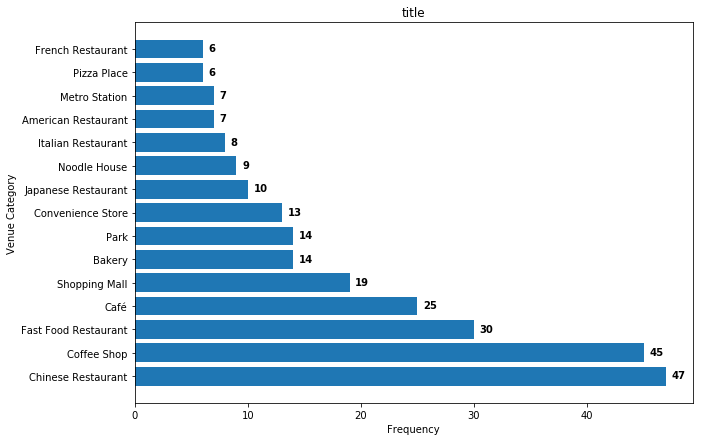

In [20]:
fig, ax= plt.subplots(figsize=(10,7))
ax.barh(shang_top15['Venue_Category'], shang_top15['Frequency'])
plt.title('title')
plt.xlabel('Frequency')
plt.ylabel('Venue Category') 
for i, v in enumerate(shang_top15['Frequency']):
    ax.text(v+.5, i-.1, str(v), color='black', fontweight='bold')

<b>Using this list, onehot encoded dataframe was created to compare which hotels had more popular places nearby and the number was totalled and added to a new 'Sum' column.</b>

In [21]:
# Use One Hot Encoding to Get More Information about the Venue Categories 
shang_venues_onehot = pd.get_dummies(shang_venues_near_hotels[['Venue_Category']], prefix="", prefix_sep="")

shang_venues_onehot['Hotel'] = shang_venues_near_hotels['Hotel'] 

fixed_columns = [shang_venues_onehot.columns[-1]] + list(shang_venues_onehot.columns[:-1])
shang_venues_onehot = shang_venues_onehot[fixed_columns]

In [22]:
shang_venues_grouped = shang_venues_onehot.groupby('Hotel').mean().reset_index()
shang_venues_grouped.index = np.arange(1, len(shang_venues_grouped)+1)
shang_venues_grouped

,Hotel,American Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Big Box Store,...,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Xinjiang Restaurant,Yoga Studio
1,"Andaz Xintiandi, Shanghai (上海新天地安达仕酒店)",0.032258,0.000000,0.010753,0.010753,0.010753,0.010753,0.000000,0.010753,0.000000,...,0.010753,0.000000,0.000000,0.000000,0.000000,0.032258,0.010753,0.010753,0.000000,0.010753
2,BaoLong Home Hotel Shanghai,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Crowne Plaza,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Crowne Plaza Century Park Shanghai (上海世纪皇冠假日酒店),0.000000,0.000000,0.000000,0.029412,0.000000,0.058824,0.000000,0.029412,0.000000,...,0.000000,0.000000,0.000000,0.029412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,"Four Points by Sheraton Shanghai, Daning",0.000000,0.000000,0.000000,0.000000,0.000000,0.074074,0.000000,0.000000,0.000000,...,0.000000,0.037037,0.000000,0.037037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Fraser Residence Shanghai,0.022472,0.011236,0.011236,0.011236,0.011236,0.011236,0.000000,0.000000,0.000000,...,0.011236,0.000000,0.000000,0.000000,0.000000,0.022472,0.011236,0.011236,0.011236,0.011236
7,"Hyatt Regency Shanghai, Wujiaochang (上海五角场凯悦酒店)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021277,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.021277,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Neo-Sunshine Hotel,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Parkview Hotel,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035714,0.000000
10,Pullman Shanghai South (中星铂尔曼酒店),0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [23]:
def most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 15

indicators = ['st', 'nd', 'rd']

columns = ['Hotel']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

District_top15_venues_sorted = pd.DataFrame(columns=columns)
District_top15_venues_sorted['Hotel'] = shang_venues_grouped['Hotel']

for ind in np.arange(shang_venues_grouped.shape[0]):
    District_top15_venues_sorted.iloc[ind, 1:] = most_common_venues(shang_venues_grouped.iloc[ind, :], num_top_venues)

    
District_top15_venues_sorted.index = np.arange(1, len(District_top15_venues_sorted)+1)
District_top15_venues_sorted

,Hotel,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
1,"Andaz Xintiandi, Shanghai (上海新天地安达仕酒店)",Chinese Restaurant,Café,Restaurant,Coffee Shop,Park,American Restaurant,Shopping Mall,Cocktail Bar,Noodle House,Vegetarian / Vegan Restaurant,Dumpling Restaurant,Shanghai Restaurant,Italian Restaurant,Gastropub,Gym
2,BaoLong Home Hotel Shanghai,Neighborhood,Coffee Shop,Lake,Chinese Restaurant,Yoga Studio,Dim Sum Restaurant,Diner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Food Truck,French Restaurant
3,Crowne Plaza,Coffee Shop,Clothing Store,Shopping Mall,Yoga Studio,Cosmetics Shop,Dessert Shop,Dim Sum Restaurant,Diner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Food Truck
4,Crowne Plaza Century Park Shanghai (上海世纪皇冠假日酒店),Fast Food Restaurant,Coffee Shop,Bakery,Convenience Store,Pub,Chinese Restaurant,Shopping Mall,Buffet,Italian Restaurant,Korean Restaurant,French Restaurant,Flea Market,Performing Arts Venue,Shopping Plaza,Café
5,"Four Points by Sheraton Shanghai, Daning",Chinese Restaurant,Coffee Shop,Bakery,Fast Food Restaurant,Café,Grocery Store,Plaza,Shopping Mall,Tea Room,Park,Korean Restaurant,Multiplex,Burger Joint,Thai Restaurant,Convenience Store
6,Fraser Residence Shanghai,Chinese Restaurant,Coffee Shop,Café,Park,Shanghai Restaurant,Noodle House,Shopping Mall,Gym,Gastropub,Mexican Restaurant,Restaurant,Department Store,American Restaurant,Cocktail Bar,Chocolate Shop
7,"Hyatt Regency Shanghai, Wujiaochang (上海五角场凯悦酒店)",Chinese Restaurant,Coffee Shop,Fast Food Restaurant,Shopping Mall,Karaoke Bar,Stadium,Café,Electronics Store,Cantonese Restaurant,Road,Bubble Tea Shop,Dessert Shop,Pizza Place,Mexican Restaurant,Middle Eastern Restaurant
8,Neo-Sunshine Hotel,Convenience Store,Chinese Restaurant,Taiwanese Restaurant,Supermarket,Yoga Studio,Food Truck,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant
9,Parkview Hotel,Coffee Shop,Convenience Store,Fast Food Restaurant,Chinese Restaurant,Bakery,Italian Restaurant,Japanese Restaurant,Xinjiang Restaurant,Korean Restaurant,French Restaurant,Flea Market,Performing Arts Venue,Plaza,Science Museum,Shopping Mall
10,Pullman Shanghai South (中星铂尔曼酒店),Fast Food Restaurant,Bus Station,Coffee Shop,Supermarket,Plaza,Cosmetics Shop,Convenience Store,Shopping Mall,Café,Ice Cream Shop,BBQ Joint,Bookstore,French Restaurant,Diner,Dumpling Restaurant


In [27]:
#shang_venues_grouped_new['Hotel'] = shang_venues_grouped['Hotel']
shang_venues_grouped = shang_venues_grouped.filter(shang_venues_grouped[shang_top15['Venue_Category']])
shang_venues_grouped.insert(0, 'Hotel', District_top15_venues_sorted['Hotel'])
shang_venues_grouped

,Hotel,Chinese Restaurant,Coffee Shop,Fast Food Restaurant,Café,Shopping Mall,Bakery,Park,Convenience Store,Japanese Restaurant,Noodle House,Italian Restaurant,American Restaurant,Metro Station,Pizza Place,French Restaurant
1,"Andaz Xintiandi, Shanghai (上海新天地安达仕酒店)",0.107527,0.043011,0.000000,0.064516,0.032258,0.010753,0.043011,0.000000,0.010753,0.032258,0.021505,0.032258,0.000000,0.010753,0.010753
2,BaoLong Home Hotel Shanghai,0.250000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Crowne Plaza,0.000000,0.333333,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Crowne Plaza Century Park Shanghai (上海世纪皇冠假日酒店),0.058824,0.117647,0.147059,0.029412,0.058824,0.058824,0.000000,0.058824,0.000000,0.000000,0.029412,0.000000,0.000000,0.000000,0.029412
5,"Four Points by Sheraton Shanghai, Daning",0.222222,0.111111,0.074074,0.074074,0.037037,0.074074,0.037037,0.037037,0.000000,0.000000,0.000000,0.000000,0.037037,0.000000,0.000000
6,Fraser Residence Shanghai,0.089888,0.078652,0.000000,0.067416,0.033708,0.011236,0.044944,0.000000,0.011236,0.033708,0.011236,0.022472,0.000000,0.011236,0.011236
7,"Hyatt Regency Shanghai, Wujiaochang (上海五角场凯悦酒店)",0.127660,0.127660,0.063830,0.042553,0.063830,0.000000,0.021277,0.021277,0.000000,0.000000,0.000000,0.000000,0.000000,0.021277,0.000000
8,Neo-Sunshine Hotel,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Parkview Hotel,0.071429,0.142857,0.107143,0.000000,0.035714,0.071429,0.000000,0.107143,0.035714,0.000000,0.035714,0.000000,0.000000,0.000000,0.035714
10,Pullman Shanghai South (中星铂尔曼酒店),0.000000,0.071429,0.214286,0.071429,0.071429,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [28]:
shang_venues_grouped['Sum'] = shang_venues_grouped.sum(axis=1)
shang_venues_grouped

,Hotel,Chinese Restaurant,Coffee Shop,Fast Food Restaurant,Café,Shopping Mall,Bakery,Park,Convenience Store,Japanese Restaurant,Noodle House,Italian Restaurant,American Restaurant,Metro Station,Pizza Place,French Restaurant,Sum
1,"Andaz Xintiandi, Shanghai (上海新天地安达仕酒店)",0.107527,0.043011,0.000000,0.064516,0.032258,0.010753,0.043011,0.000000,0.010753,0.032258,0.021505,0.032258,0.000000,0.010753,0.010753,0.419355
2,BaoLong Home Hotel Shanghai,0.250000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000
3,Crowne Plaza,0.000000,0.333333,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667
4,Crowne Plaza Century Park Shanghai (上海世纪皇冠假日酒店),0.058824,0.117647,0.147059,0.029412,0.058824,0.058824,0.000000,0.058824,0.000000,0.000000,0.029412,0.000000,0.000000,0.000000,0.029412,0.588235
5,"Four Points by Sheraton Shanghai, Daning",0.222222,0.111111,0.074074,0.074074,0.037037,0.074074,0.037037,0.037037,0.000000,0.000000,0.000000,0.000000,0.037037,0.000000,0.000000,0.703704
6,Fraser Residence Shanghai,0.089888,0.078652,0.000000,0.067416,0.033708,0.011236,0.044944,0.000000,0.011236,0.033708,0.011236,0.022472,0.000000,0.011236,0.011236,0.426966
7,"Hyatt Regency Shanghai, Wujiaochang (上海五角场凯悦酒店)",0.127660,0.127660,0.063830,0.042553,0.063830,0.000000,0.021277,0.021277,0.000000,0.000000,0.000000,0.000000,0.000000,0.021277,0.000000,0.489362
8,Neo-Sunshine Hotel,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000
9,Parkview Hotel,0.071429,0.142857,0.107143,0.000000,0.035714,0.071429,0.000000,0.107143,0.035714,0.000000,0.035714,0.000000,0.000000,0.000000,0.035714,0.642857
10,Pullman Shanghai South (中星铂尔曼酒店),0.000000,0.071429,0.214286,0.071429,0.071429,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000


In [29]:
import geopy.distance

shang_airport = (31.1443, 121.8083)
shang_hotel = shang_hotels.sort_values(by=['Hotel'])
hotel_x = list(shang_hotel['Hotel_Lat'])
hotel_y = list(shang_hotel['Hotel_Long'])

distance_from_airport = []

for i in range(len(hotel_x)):
    distance_from_airport.append(geopy.distance.distance(shang_airport,(hotel_x[i],hotel_y[i])).km)
distance_from_airport

[32.87646654785024,
 59.34313438654947,
 64.40703895674669,
 26.45772769155727,
 36.87930436781522,
 32.917222148359045,
 33.008691516294796,
 58.84757781450469,
 27.24399105454618,
 36.58399778469824,
 41.194021944976804,
 26.399932420036162,
 40.922398633248214,
 34.895072457142554,
 36.2265235184019,
 57.73526841386815,
 31.514158606669845]

In [30]:
shang_hotel_kmeans = pd.DataFrame(shang_venues_grouped['Sum'])
shang_hotel_kmeans['Distance'] = distance_from_airport
shang_hotel_kmeans

,Sum,Distance
1,0.419355,32.876467
2,0.500000,59.343134
3,0.666667,64.407039
4,0.588235,26.457728
5,0.703704,36.879304
6,0.426966,32.917222
7,0.489362,33.008692
8,0.600000,58.847578
9,0.642857,27.243991
10,0.500000,36.583998


In [31]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(shang_hotel_kmeans)

# check cluster labels generated for each row in the dataframe
print ("Cluster Labels :",  kmeans.labels_)

Cluster Labels : [2 1 1 3 4 2 2 1 3 4 0 3 0 4 4 1 2]


In [32]:
#shang_hotel_kmeans = shang_hotel_kmeans.drop(columns = 'Hotel', axis=)
shang_hotel_kmeans.insert(0, 'Hotel', shang_venues_grouped['Hotel'])
shang_hotel_kmeans.insert(3, 'Cluster Label', kmeans.labels_)
shang_hotel = shang_hotels.sort_values(by='Hotel')
shang_hotel.index = np.arange(1, len(shang_hotel)+1)
#shang_hotel_kmeans = shang_hotel_kmeans.drop(columns = ['Hotel_Lat','Hotel_Long'], axis=1)
shang_hotel_kmeans.insert(4,'Hotel_Lat', shang_hotel['Hotel_Lat'])
shang_hotel_kmeans.insert(5,'Hotel_Long', shang_hotel['Hotel_Long'])

#Tokyo_5_Dist_Coordinate_Cluster_merged = Tokyo_df_selected_final

#merge the inital Tokyo Dataframe with Sorted Most Visited places for each neighborhood

shang_merged = shang_hotel_kmeans.join(District_top15_venues_sorted.set_index('Hotel'), on='Hotel')

shang_merged

,Hotel,Sum,Distance,Cluster Label,Hotel_Lat,Hotel_Long,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,...,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
1,"Andaz Xintiandi, Shanghai (上海新天地安达仕酒店)",0.419355,32.876467,2,31.221941,121.475431,Chinese Restaurant,Café,Restaurant,Coffee Shop,...,American Restaurant,Shopping Mall,Cocktail Bar,Noodle House,Vegetarian / Vegan Restaurant,Dumpling Restaurant,Shanghai Restaurant,Italian Restaurant,Gastropub,Gym
2,BaoLong Home Hotel Shanghai,0.500000,59.343134,1,31.030738,121.200523,Neighborhood,Coffee Shop,Lake,Chinese Restaurant,...,Dim Sum Restaurant,Diner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Food Truck,French Restaurant
3,Crowne Plaza,0.666667,64.407039,1,31.153690,121.132946,Coffee Shop,Clothing Store,Shopping Mall,Yoga Studio,...,Dessert Shop,Dim Sum Restaurant,Diner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Food Truck
4,Crowne Plaza Century Park Shanghai (上海世纪皇冠假日酒店),0.588235,26.457728,3,31.225281,121.547203,Fast Food Restaurant,Coffee Shop,Bakery,Convenience Store,...,Chinese Restaurant,Shopping Mall,Buffet,Italian Restaurant,Korean Restaurant,French Restaurant,Flea Market,Performing Arts Venue,Shopping Plaza,Café
5,"Four Points by Sheraton Shanghai, Daning",0.703704,36.879304,4,31.273794,121.451831,Chinese Restaurant,Coffee Shop,Bakery,Fast Food Restaurant,...,Grocery Store,Plaza,Shopping Mall,Tea Room,Park,Korean Restaurant,Multiplex,Burger Joint,Thai Restaurant,Convenience Store
6,Fraser Residence Shanghai,0.426966,32.917222,2,31.225639,121.476177,Chinese Restaurant,Coffee Shop,Café,Park,...,Noodle House,Shopping Mall,Gym,Gastropub,Mexican Restaurant,Restaurant,Department Store,American Restaurant,Cocktail Bar,Chocolate Shop
7,"Hyatt Regency Shanghai, Wujiaochang (上海五角场凯悦酒店)",0.489362,33.008692,2,31.302408,121.514755,Chinese Restaurant,Coffee Shop,Fast Food Restaurant,Shopping Mall,...,Stadium,Café,Electronics Store,Cantonese Restaurant,Road,Bubble Tea Shop,Dessert Shop,Pizza Place,Mexican Restaurant,Middle Eastern Restaurant
8,Neo-Sunshine Hotel,0.600000,58.847578,1,31.028412,121.206445,Convenience Store,Chinese Restaurant,Taiwanese Restaurant,Supermarket,...,Food Truck,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant
9,Parkview Hotel,0.642857,27.243991,3,31.225966,121.538728,Coffee Shop,Convenience Store,Fast Food Restaurant,Chinese Restaurant,...,Italian Restaurant,Japanese Restaurant,Xinjiang Restaurant,Korean Restaurant,French Restaurant,Flea Market,Performing Arts Venue,Plaza,Science Museum,Shopping Mall
10,Pullman Shanghai South (中星铂尔曼酒店),0.500000,36.583998,4,31.161600,121.425152,Fast Food Restaurant,Bus Station,Coffee Shop,Supermarket,...,Cosmetics Shop,Convenience Store,Shopping Mall,Café,Ice Cream Shop,BBQ Joint,Bookstore,French Restaurant,Diner,Dumpling Restaurant


<b>After this, the distance of each hotel from the Shanghai airport was calculated. This was done because many a times businesspersons prefer to reduce transport time to and from the airport. Using these two parameters, clustering analysis was conducted and displayed on a <u>folium</u> map.</b>

In [33]:
# create map
map_clusters = folium.Map(location=[shang_latitude, shang_longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(shang_merged['Hotel_Lat'], 
                                  shang_merged['Hotel_Long'], 
                                  shang_merged['Hotel'], 
                                  shang_merged['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=colorscheme[cluster*2-1],
        fill=True,
        fill_color=colorscheme[cluster*2-1],
        fill_opacity=0.7).add_to(map_clusters)
#folium.PolyLine(), color="red", weight=2.5, opacity=1).add_to(map_clusters)

folium.Marker(shang_airport,popup='Shanghai Intl Airport').add_to(map_clusters)
map_clusters


In [34]:
shang_cluster1 = shang_merged.loc[shang_merged['Cluster Label'] == 0]
print ("No of Hotels in Cluster Label 0: %d" %(shang_cluster1.shape[0]))
shang_cluster1.index = np.arange(1,shang_cluster1.shape[0]+1)
shang_cluster1

No of Hotels in Cluster Label 0: 2


,Hotel,Sum,Distance,Cluster Label,Hotel_Lat,Hotel_Long,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,...,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
1,Radisson Blu Hotel Shanghai Hong Quan,0.222222,41.194022,0,31.260797,121.397849,Seafood Restaurant,Soccer Field,Food Truck,Train Station,...,Metro Station,Supermarket,Fast Food Restaurant,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
2,Ruitai Hongqiao Hotel (瑞泰虹桥酒店),0.615385,40.922399,0,31.212176,121.386333,Japanese Restaurant,Chinese Restaurant,Coffee Shop,Café,...,Fast Food Restaurant,Cantonese Restaurant,BBQ Joint,Korean Restaurant,French Restaurant,Karaoke Bar,Dumpling Restaurant,Grocery Store,Ramen Restaurant,Sandwich Place


In [35]:
shang_cluster2 = shang_merged.loc[shang_merged['Cluster Label'] == 1]
print ("No of Hotels in Cluster Label 2: %d" %(shang_cluster2.shape[0]))
shang_cluster2.index = np.arange(1,shang_cluster2.shape[0]+1)
shang_cluster2

No of Hotels in Cluster Label 2: 4


,Hotel,Sum,Distance,Cluster Label,Hotel_Lat,Hotel_Long,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,...,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
1,BaoLong Home Hotel Shanghai,0.500000,59.343134,1,31.030738,121.200523,Neighborhood,Coffee Shop,Lake,Chinese Restaurant,...,Dim Sum Restaurant,Diner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Food Truck,French Restaurant
2,Crowne Plaza,0.666667,64.407039,1,31.153690,121.132946,Coffee Shop,Clothing Store,Shopping Mall,Yoga Studio,...,Dessert Shop,Dim Sum Restaurant,Diner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Food Truck
3,Neo-Sunshine Hotel,0.600000,58.847578,1,31.028412,121.206445,Convenience Store,Chinese Restaurant,Taiwanese Restaurant,Supermarket,...,Food Truck,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant
4,Shanghai Vienna Hotel,0.571429,57.735268,1,31.036080,121.216409,Coffee Shop,Movie Theater,Big Box Store,Park,...,Supermarket,Food Truck,Dessert Shop,Dim Sum Restaurant,Diner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Farmers Market,Flea Market


In [36]:
shang_cluster3 = shang_merged.loc[shang_merged['Cluster Label'] == 2]
print ("No of Hotels in Cluster Label 3: %d" %(shang_cluster3.shape[0]))
shang_cluster3.index = np.arange(1,shang_cluster3.shape[0]+1)
shang_cluster3

No of Hotels in Cluster Label 3: 4


,Hotel,Sum,Distance,Cluster Label,Hotel_Lat,Hotel_Long,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,...,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
1,"Andaz Xintiandi, Shanghai (上海新天地安达仕酒店)",0.419355,32.876467,2,31.221941,121.475431,Chinese Restaurant,Café,Restaurant,Coffee Shop,...,American Restaurant,Shopping Mall,Cocktail Bar,Noodle House,Vegetarian / Vegan Restaurant,Dumpling Restaurant,Shanghai Restaurant,Italian Restaurant,Gastropub,Gym
2,Fraser Residence Shanghai,0.426966,32.917222,2,31.225639,121.476177,Chinese Restaurant,Coffee Shop,Café,Park,...,Noodle House,Shopping Mall,Gym,Gastropub,Mexican Restaurant,Restaurant,Department Store,American Restaurant,Cocktail Bar,Chocolate Shop
3,"Hyatt Regency Shanghai, Wujiaochang (上海五角场凯悦酒店)",0.489362,33.008692,2,31.302408,121.514755,Chinese Restaurant,Coffee Shop,Fast Food Restaurant,Shopping Mall,...,Stadium,Café,Electronics Store,Cantonese Restaurant,Road,Bubble Tea Shop,Dessert Shop,Pizza Place,Mexican Restaurant,Middle Eastern Restaurant
4,WH Ming Hotel (小南国花园大酒店),0.625000,31.514159,2,31.291290,121.525227,Park,Ice Cream Shop,Pizza Place,Asian Restaurant,...,Metro Station,Supermarket,Food Truck,Dim Sum Restaurant,Diner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant


In [37]:
shang_cluster4 = shang_merged.loc[shang_merged['Cluster Label'] == 3]
print ("No of Hotels in Cluster Label 4: %d" %(shang_cluster4.shape[0]))
shang_cluster4.index = np.arange(1,shang_cluster4.shape[0]+1)
shang_cluster4

No of Hotels in Cluster Label 4: 3


,Hotel,Sum,Distance,Cluster Label,Hotel_Lat,Hotel_Long,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,...,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
1,Crowne Plaza Century Park Shanghai (上海世纪皇冠假日酒店),0.588235,26.457728,3,31.225281,121.547203,Fast Food Restaurant,Coffee Shop,Bakery,Convenience Store,...,Chinese Restaurant,Shopping Mall,Buffet,Italian Restaurant,Korean Restaurant,French Restaurant,Flea Market,Performing Arts Venue,Shopping Plaza,Café
2,Parkview Hotel,0.642857,27.243991,3,31.225966,121.538728,Coffee Shop,Convenience Store,Fast Food Restaurant,Chinese Restaurant,...,Italian Restaurant,Japanese Restaurant,Xinjiang Restaurant,Korean Restaurant,French Restaurant,Flea Market,Performing Arts Venue,Plaza,Science Museum,Shopping Mall
3,Renaissance Shanghai Pudong Hotel (上海淳大万丽酒店),0.633333,26.399932,3,31.225783,121.548058,Coffee Shop,Fast Food Restaurant,Convenience Store,Pub,...,Bakery,Shopping Mall,Italian Restaurant,Breakfast Spot,Flea Market,Shopping Plaza,Café,French Restaurant,Buffet,Korean Restaurant


In [38]:
shang_cluster5 = shang_merged.loc[shang_merged['Cluster Label'] == 4]
print ("No of Hotels in Cluster Label 5: %d" %(shang_cluster5.shape[0]))
shang_cluster5.index = np.arange(1,shang_cluster5.shape[0]+1)
shang_cluster5

No of Hotels in Cluster Label 5: 4


,Hotel,Sum,Distance,Cluster Label,Hotel_Lat,Hotel_Long,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,...,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
1,"Four Points by Sheraton Shanghai, Daning",0.703704,36.879304,4,31.273794,121.451831,Chinese Restaurant,Coffee Shop,Bakery,Fast Food Restaurant,...,Grocery Store,Plaza,Shopping Mall,Tea Room,Park,Korean Restaurant,Multiplex,Burger Joint,Thai Restaurant,Convenience Store
2,Pullman Shanghai South (中星铂尔曼酒店),0.500000,36.583998,4,31.161600,121.425152,Fast Food Restaurant,Bus Station,Coffee Shop,Supermarket,...,Cosmetics Shop,Convenience Store,Shopping Mall,Café,Ice Cream Shop,BBQ Joint,Bookstore,French Restaurant,Diner,Dumpling Restaurant
3,SISU Guest House (SISU Guest House Hotel Shang...,0.613636,34.895072,4,31.279578,121.477662,Coffee Shop,Fast Food Restaurant,Café,Chinese Restaurant,...,Pizza Place,Ramen Restaurant,Juice Bar,Japanese Restaurant,Italian Restaurant,Multiplex,Metro Station,Eastern European Restaurant,Soccer Stadium,Park
4,Shanghai Holand Hotel,0.500000,36.226524,4,31.265858,121.455452,Fast Food Restaurant,Metro Station,Road,Tea Room,...,Noodle House,Taiwanese Restaurant,Bus Station,Gym,Korean Restaurant,Bakery,Coffee Shop,Flea Market,Dumpling Restaurant,Eastern European Restaurant


# Results 
<font size="4"> As seen from the above analysis, we can infer the following:<br>
<ul>
    <li>Clusters are influenced by the distance from the airport. If we followed an imaginary radius with the airport as a concurrent centre, we can identify that all the hotels fit in ideal clusters that can be imagined to be on a circle.
    <li>The venues that are nearby hotels equally influence the cluster analysis. No two hotels in a cluster (bar the first one, which indicates an outlier) have a difference of more than 0.25 in terms of their sums.
    <li>Only 4 hotels have a sum of less than 0.5, indicating that popular venues in Shanghai are also located near the hotels.
</ul>


# Discussion/Conclusion

Using Foursquare API, we have collected a decent amount of hotel recommnedations in Shanghai. However, it has its limiations as we do not have an exhaustive list of all the available hotels, restaraunts, cafes, etc.<br>

The generated clusters indicate that there are a lot of popular venues in close proximity of the Hotels. However, this doesn't mean that one influences the other (Correlation doesn't imply causation). Travellers who are on a decent budget and want to explore the local culture will find this catalogue the most useful. Businesspersons can also make use of this catalogue to understand how far their hotel will be from the airport, and if they have any spare time, which places they can visit.<br>

Since this also includes a graph of most popular venues, people can identify those places and manually choose to visit them. The most popular venues are Chinese restaraunts, Cafes in general and fast food outlets.<br>

In conclusion, I would like to thank Coursera and IBM for allowing me to create this informative and helpful project and hone my skills for the future.